<a href="https://colab.research.google.com/github/Aditic1/Cart-Abandonment-Analysis/blob/main/Cart%20Abandonment%20Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files

# Upload kaggle.json
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aditic197","key":"de29ecce2faad3ce3caf3648efcec069"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Secure the file


# Import Dataset for Cart Abandonment

In [ ]:
!kaggle datasets download -d dynamo21/cart-abandonment


Dataset URL: https://www.kaggle.com/datasets/dynamo21/cart-abandonment
License(s): unknown
  0% 0.00/55.8k [00:00<?, ?B/s]
100% 55.8k/55.8k [00:00<00:00, 106MB/s]


Extract the Dataset

In [ ]:
import zipfile

# Unzip the dataset
with zipfile.ZipFile("cart-abandonment.zip", "r") as zip_ref:
    zip_ref.extractall("cart-abandonment")

# List extracted files
!ls cart-abandonment


customer_table.csv  date_table.csv  device_table.csv  fact_table.csv  product_table.csv


Import the libraries

In [ ]:
# Importing Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import warnings
warnings.filterwarnings('ignore')

# Check the datasets

In [ ]:
customer = pd.read_csv('/content/cart-abandonment/customer_table.csv')
date = pd.read_csv('/content/cart-abandonment/date_table.csv')
product = pd.read_csv('/content/cart-abandonment/product_table.csv')
fact = pd.read_csv('/content/cart-abandonment/fact_table.csv')
device = pd.read_csv('/content/cart-abandonment/device_table.csv')

# Reading the Datasets

In [ ]:
print('Size of customer table:', customer.shape)
print('Size of date table:', date.shape)
print('Size of product table:', product.shape)
print('Size of fact table:', fact.shape)


Size of customer table: (1000, 5)
Size of date table: (366, 2)
Size of product table: (25, 4)
Size of fact table: (5000, 7)


In [ ]:
customer.head()

,customer_id,customer_name,age,gender,city
0,1,Customer 1,49,Female,London
1,2,Customer 2,45,Male,London
2,3,Customer 3,51,Male,London
3,4,Customer 4,38,Male,New York
4,5,Customer 5,26,Male,London


In [ ]:
date.head()

,date_id,date
0,1,1/1/2023
1,2,1/2/2023
2,3,1/3/2023
3,4,1/4/2023
4,5,1/5/2023


In [ ]:
device.head()

,device_id,device_type,os
0,1,Tablet,iOS
1,2,Desktop,iOS
2,3,Mobile,Windows
3,4,Mobile,Android
4,5,Tablet,iOS


In [ ]:
product.head()

,product_id,product_name,category,price
0,1,Laptop,Electronics,1026.94
1,2,Smartphone,Electronics,641.94
2,3,Headphones,Electronics,866.21
3,4,Smartwatch,Electronics,1221.77
4,5,Camera,Electronics,1290.76


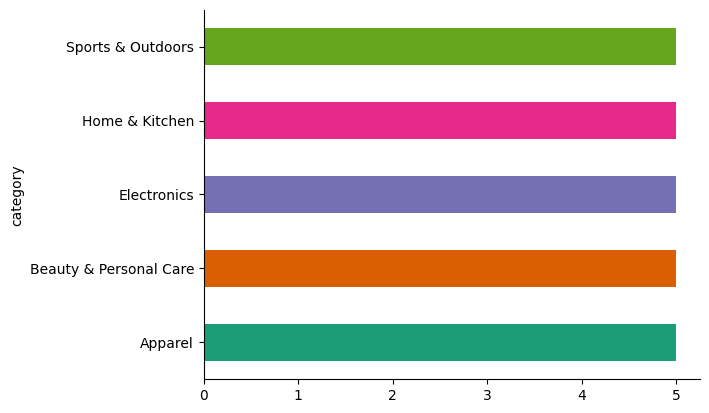

In [ ]:
# @title category

from matplotlib import pyplot as plt
import seaborn as sns
product.groupby('category').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
fact.head()

,session_id,customer_id,product_id,device_id,date_id,quantity,abandonment_time
0,1,979,20,5,252,4,7/13/2023
1,2,373,12,3,353,2,11/7/2023
2,3,32,3,4,286,2,3/3/2023
3,4,631,25,1,365,2,NaN
4,5,127,9,3,163,3,7/22/2023


In [ ]:
date.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   date_id  366 non-null    int64 
 1   date     366 non-null    object
dtypes: int64(1), object(1)
memory usage: 5.8+ KB


In [ ]:
date['date'] = pd.to_datetime(date['date'])
date.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date_id  366 non-null    int64         
 1   date     366 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 5.8 KB


#Consider the analysis for only 1 year

In [ ]:
date = date[date['date'].dt.year==2023]

In [ ]:
date.info()

<class 'pandas.core.frame.DataFrame'>
Index: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date_id  365 non-null    int64         
 1   date     365 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 8.6 KB


In [ ]:
fact.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   session_id        5000 non-null   int64 
 1   customer_id       5000 non-null   int64 
 2   product_id        5000 non-null   int64 
 3   device_id         5000 non-null   int64 
 4   date_id           5000 non-null   int64 
 5   quantity          5000 non-null   int64 
 6   abandonment_time  2524 non-null   object
dtypes: int64(6), object(1)
memory usage: 273.6+ KB


In [ ]:
fact['abandonment_time'] = pd.to_datetime(fact['abandonment_time'])
fact.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   session_id        5000 non-null   int64         
 1   customer_id       5000 non-null   int64         
 2   product_id        5000 non-null   int64         
 3   device_id         5000 non-null   int64         
 4   date_id           5000 non-null   int64         
 5   quantity          5000 non-null   int64         
 6   abandonment_time  2524 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(6)
memory usage: 273.6 KB


In [ ]:
fact.isnull().sum()

,0
session_id,0
customer_id,0
product_id,0
device_id,0
date_id,0
quantity,0
abandonment_time,2476


In [ ]:
fact.duplicated().sum()

0

# Data Analysis

1. Demographic Insights

In [ ]:
print('The no of customers = ',customer['customer_id'].count())

The no of customers =  1000


In [ ]:
# Group by city and count the number of people
city_demographic = customer.groupby('city').size().reset_index(name='number_of_people')

city_demographic

,city,number_of_people
0,Berlin,206
1,London,187
2,Mumbai,185
3,New York,209
4,Sydney,213


i). Citywise Distribution

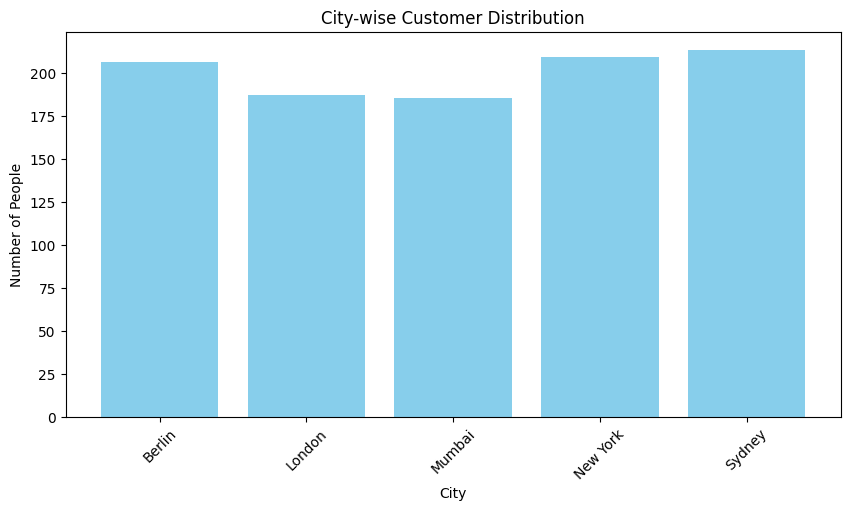

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(city_demographic['city'], city_demographic['number_of_people'], color='skyblue')

# Labels and title
plt.xlabel("City")
plt.ylabel("Number of People")
plt.title("City-wise Customer Distribution")
plt.xticks(rotation=45)  # Rotate city names for better readability

# Show plot
plt.show()


ii). Age distribution

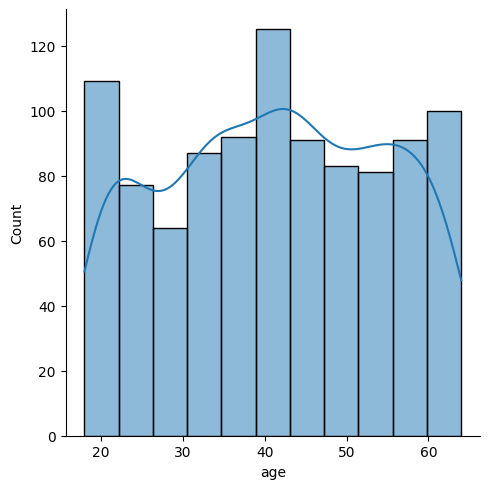

In [ ]:
sns.displot(customer['age'], kde=True)
plt.show()

In [ ]:
# Count number of customers by gender
gender_distribution = customer['gender'].value_counts()

# Convert to DataFrame for better readability
gender_df = gender_distribution.reset_index()
gender_df.columns = ['Gender', 'Count']

# Print the table
print(gender_df)


   Gender  Count
0  Female    501
1    Male    499


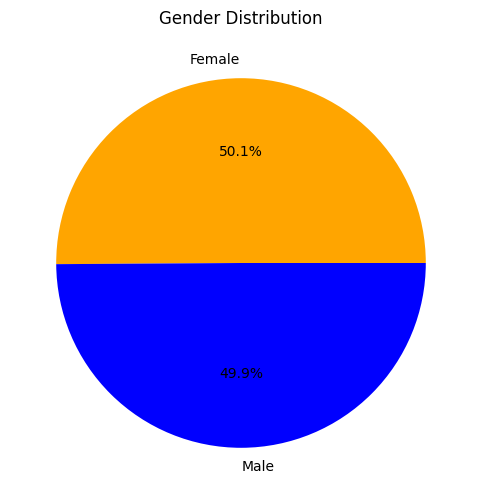

In [ ]:
plt.figure(figsize=(6, 6))
plt.pie(gender_distribution, labels=gender_distribution.index, autopct='%1.1f%%', colors=['Orange', 'Blue'])

# Title
plt.title("Gender Distribution")

# Show plot
plt.show()

Gender Distribution according to city

In [ ]:
city_gender=customer.groupby(['city','gender']).agg({'customer_id':'count'}).rename(columns={'customer_id':'customer count'}).reset_index()

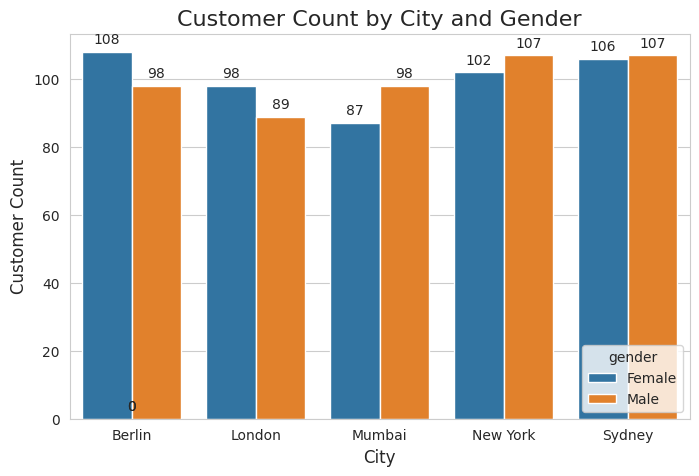

In [ ]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create the bar plot
plt.figure(figsize=(8, 5))
barplot = sns.barplot(x='city', y='customer count', hue='gender', data=city_gender)

# Add data labels on the bars
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'),  # Format the label
                     (p.get_x() + p.get_width() / 2., p.get_height()),  # Position the label
                     ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=10)

# Add title and labels
plt.title('Customer Count by City and Gender', fontsize=16)
plt.xlabel('City', fontsize=12)
plt.ylabel('Customer Count', fontsize=12)

# Display plot
plt.show()

2. Product Analysis

In [ ]:
# inner join of product and fact
product_cart=pd.merge(product,fact,how='inner',on='product_id')
#Group by and aggregate based on product and quantitify of each

product_cart_qty=product_cart.groupby(['product_name']).agg({'quantity':'sum'}).reset_index()

#Rank define
product_cart_qty['Rank']=product_cart_qty['quantity'].rank(method='dense',ascending=False)
#find top 10 products
top_10_product=product_cart_qty[product_cart_qty['Rank']<=10].sort_values(by=['Rank'])


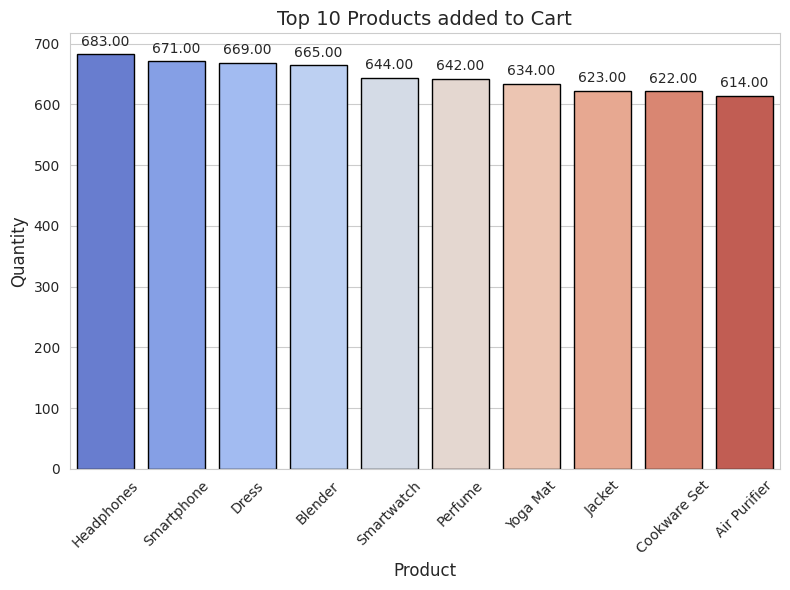

In [ ]:
plt.figure(figsize=(8,6))

#create a bar plot using seaborn
ax = sns.barplot(x='product_name',y='quantity',data=top_10_product,palette='coolwarm',edgecolor='black')

#rotate labels on x by 45 deg for better viewing
plt.xticks(rotation=45)

# Adding title and labels
plt.title('Top 10 Products added to Cart', fontsize=14)
plt.xlabel('Product', fontsize=12)
plt.ylabel('Quantity', fontsize=12)

# Adding values on top of bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9), textcoords = 'offset points')

# Display the plot
plt.tight_layout()
plt.show()


Top 3 products of each category

In [ ]:
#Group by category to which the product belongs
category_product_cart = product_cart.groupby(['category','product_name']).agg({'quantity':'sum'}).reset_index()
#Top products/quantities added to the cart
category_product_cart['Rank'] = category_product_cart.groupby('category')['quantity'].rank(method='dense', ascending=False)

top_2_cateory_product = category_product_cart[category_product_cart['Rank'] <= 3].sort_values(by=['category', 'Rank'],ascending=[True,True])

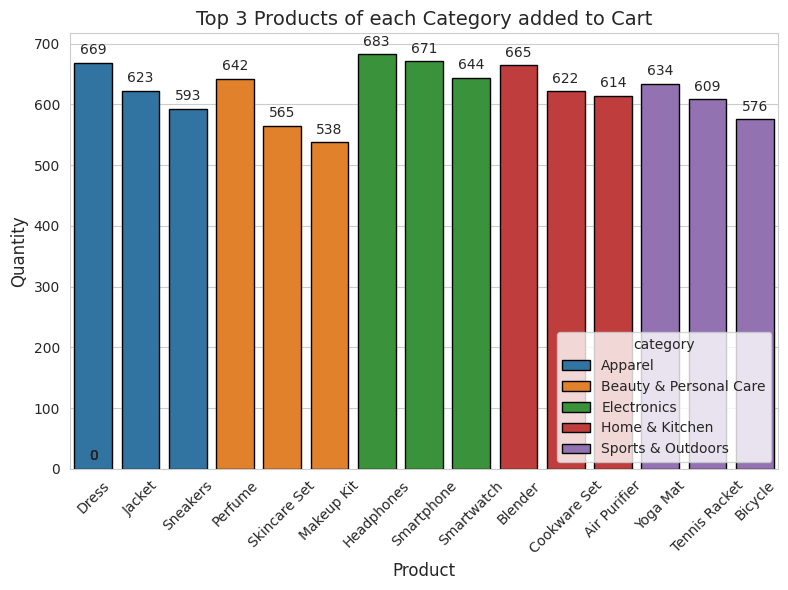

In [ ]:
# Setting figure size
plt.figure(figsize=(8,6))

# Creating bar plot using seaborn
ax = sns.barplot(x='product_name', y='quantity', data=top_2_cateory_product, hue='category', edgecolor='black')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adding title and labels
plt.title('Top 3 Products of each Category added to Cart', fontsize=14)
plt.xlabel('Product', fontsize=12)
plt.ylabel('Quantity', fontsize=12)

# Adding values on top of bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9), textcoords = 'offset points')

# Display the plot
plt.tight_layout()
plt.show()